In [ ]:
!pip install wordcloud > /dev/null
!pip install isodate > /dev/null
!pip install --upgrade google-api-python-client > /dev/null

In [63]:
import pandas as pd
import logging
import numpy as np

from dateutil import parser
from googleapiclient.discovery import build
from IPython.display import JSON
from googleapiclient.errors import HttpError

# Visualisation packages

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP packages
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud

In [ ]:
api_key = ""
channel_ids = [
    "UCupvZG-5ko_eiXAupbDfxWw",
]
playlist_id = "UUupvZG-5ko_eiXAupbDfxWw"

In [ ]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(api_service_name, api_version, developerKey=api_key)


In [ ]:
def get_channel_stats(youtube, channel_ids):
    all_data = []  # Initialize list

    # API request to fetch channel details

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics", id=",".join(channel_ids)
    )

    response = request.execute()  # Execute the API request

    # loop through items

    for item in response["items"]:
        data = {
            "Channel Name": item["snippet"]["title"],
            "Location": item["snippet"].get("country", "N/A"),
            "Subscribers": int(item["statistics"]["subscriberCount"]),
            "Views": item["statistics"]["viewCount"],
            "Total Videos": int(item["statistics"]["videoCount"]),
            "Playlist ID": item["contentDetails"]["relatedPlaylists"]["uploads"],
        }

        all_data.append(data)  # Append data to the list

    return pd.DataFrame(all_data)  # Return a DataFrame

In [15]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [16]:
channel_stats

,Channel Name,Location,Subscribers,Views,Total Videos,Playlist ID
0,CNN,N/A,17700000,17428751276,170128,UUupvZG-5ko_eiXAupbDfxWw


In [17]:
# find video ids using 'part' (enter snippet, contentDetails) & 'playlist ID' parameters via 'Playlistitems' on youtube api references
request = youtube.playlistItems().list(
    part="snippet, contentDetails", playlistId=playlist_id
)
response = request.execute()

JSON(response)

<IPython.core.display.JSON object>

In [18]:
# create an empty list to store all video ids
playlist_id = playlist_id


def get_video_ids(youtube, playlist_id):

    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet,contentDetails", playlistId=playlist_id, maxResults=50
    )
    response = request.execute()

    # loop through all items and append the video id to the list.

    for item in response["items"]:
        video_ids.append(item["contentDetails"]["videoId"])

    # implement nextPageToken to get all video ids

    next_page_token = response.get("nextPageToken")
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="contentDetails",
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token,
        )
        response = request.execute()

        for item in response["items"]:
            video_ids.append(item["contentDetails"]["videoId"])

        next_page_token = response.get("nextPageToken")

    return video_ids

In [19]:
video_ids = get_video_ids(youtube, playlist_id)

In [21]:
print(get_video_ids)  # return a function reference

<function get_video_ids at 0x13b427560>


## Extract video info

In [22]:
request = youtube.videos().list(
    part="snippet,contentDetails,statistics",
    id=video_ids[0:5],  # returns only first five
)
response = request.execute()
JSON(response)

<IPython.core.display.JSON object>

### Create an empty dict to store all video info extracted

In [23]:
def get_video_details(youtube, video_ids):

    all_video_info = []

    request = youtube.videos().list(
        part="snippet,contentDetails,statistics",
        id=video_ids[0:5],  # returns only first five
    )

    response = request.execute()

    for video in response["items"]:
        cache_info = {
            "snippet": ["channelTitle", "title", "description", "tags", "publishedAt"],
            "statistics": ["viewCount", "likeCount", "favouriteCount", "commentCount"],
            "contentDetails": ["duration", "definition", "caption"],
        }

        video_info = {}
        video_info["video_id"] = video["id"]

        for k in cache_info.keys():
            for v in cache_info[k]:
                try:
                    video_info[v] = video[k][v]
                except:
                    video_info[v] = None

        all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

In [24]:
# Get video details

video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,WMGQiQDfuKM,CNN,Canadian couple cancels thousands in travel to...,CNN's Natasha Chen spoke to Gary and Carol Cru...,None,2025-03-10T02:10:37Z,24071,875,None,156,PT2M10S,hd,false
1,V5ypd7kJYh8,CNN,Park workers battle 120 MPH winds,Park workers braved heavy winds as gusts of ov...,None,2025-03-10T02:03:36Z,13350,552,None,30,PT33S,hd,false
2,AqTvAZuwWlU,CNN,Mark Carney addresses Trump in first remarks a...,Mark Carney has been elected leader of Canada’...,None,2025-03-10T01:09:23Z,65407,4854,None,611,PT38S,hd,false
3,7iZka5ewiQI,CNN,Fareed on global impact of Trump’s moves,"CNN’s Fareed Zakaria, host of “Fareed Zakaria ...",None,2025-03-09T22:09:51Z,12942,529,None,78,PT1M54S,hd,false
4,l_w-H7x4FwA,CNN,Fareed’s Take: Trump’s revolution in foreign p...,"Fareed Zakaria, host of “Fareed Zakaria GPS,” ...",None,2025-03-09T19:04:48Z,592868,11860,None,4067,PT5M49S,sd,true


## Extract video comments

In [26]:
# Suppress API warnings to avoid unnecessary logs

logging.getLogger("googleapiclient.http").setLevel(logging.ERROR)


def get_video_comments(youtube, video_ids, max_comments=10):
    all_comments = []

    for video_id in video_ids:
        try:
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id,
                maxResults=30,
                order="relevance",  # Fetch top comments instead of latest
            )
            response = request.execute() 

            video_comments = []
            for item in response.get("items", []):  # Handle missing items
                try:
                    comment_text = item["snippet"]["topLevelComment"]["snippet"][
                        "textOriginal"
                    ]
                    video_comments.append(comment_text)

                    # Stop collecting when max_comments is reached

                    if len(video_comments) >= max_comments:
                        break

                except KeyError:
                    continue  # Skip missing comments safely

                # except KeyError:
                # video_comments.append(None)  # Handle missing comments safely

            all_comments.append({"video_id": video_id, "comments": video_comments})

        except HttpError as e:  # Skip videos with comments disabled
            error_message = str(e)
            if "commentsDisabled" in error_message:
                continue  # Silently skip and move to the next video

    return pd.DataFrame(all_comments)

In [27]:
comments_df = get_video_comments(youtube, video_ids)

In [28]:
comments_df

,video_id,comments
0,WMGQiQDfuKM,"[Agree with this wonderful couple ❤, We can no..."
1,V5ypd7kJYh8,[Pretty sure there’s some context missing here...
2,AqTvAZuwWlU,"[As an American, I support Canada. They are ou..."
3,7iZka5ewiQI,[THE USA has tucked up the entire Globe. ❤from...
4,l_w-H7x4FwA,"[From a Norwegian: A few weeks ago, the US was..."
...,...,...
9196,3UYaG42jK7k,"[Elephant: ""It's not mine. I just found it."" [..."
9197,W48OhxvWdpQ,[It's always a tragedy when a surface to air m...
9198,aS7qeaNyp6Q,[Chris must’ve forgotten the time he closed th...
9199,PW28HA-zoCk,[IMAGINE HOW STRONG OUR COUNTRY WOULD BE IF PR...


# Data Pre-processing

In [29]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [30]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [31]:
# Convert select columns from object to integer/numeric

cols_to_integer = ["viewCount", "likeCount", "favouriteCount", "commentCount"]
video_df[cols_to_integer] = video_df[cols_to_integer].apply(
    pd.to_numeric, errors="coerce", axis=1
)

In [32]:
# Date of publishing

video_df["publishedAt"] = video_df["publishedAt"].apply(lambda x: parser.parse(x))
video_df["publishDayName"] = video_df["publishedAt"].apply(lambda x: x.strftime("%A"))

In [33]:
# Convert Duration to numeric value (seconds)

import isodate

video_df["durationSecs"] = video_df["duration"].apply(
    lambda x: isodate.parse_duration(x)
)
video_df["durationSecs"] = video_df["durationSecs"].astype("timedelta64[s]")

In [34]:
video_df[["durationSecs", "duration"]]

,durationSecs,duration
0,0 days 00:02:10,PT2M10S
1,0 days 00:00:33,PT33S
2,0 days 00:00:38,PT38S
3,0 days 00:01:54,PT1M54S
4,0 days 00:05:49,PT5M49S


In [35]:
# Add Tag count

video_df["tagCount"] = video_df["tags"].apply(lambda x: 0 if x is None else len(x))

In [36]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishDayName,durationSecs,tagCount
0,WMGQiQDfuKM,CNN,Canadian couple cancels thousands in travel to...,CNN's Natasha Chen spoke to Gary and Carol Cru...,None,2025-03-10 02:10:37+00:00,24071.0,875.0,NaN,156.0,PT2M10S,hd,false,Monday,0 days 00:02:10,0
1,V5ypd7kJYh8,CNN,Park workers battle 120 MPH winds,Park workers braved heavy winds as gusts of ov...,None,2025-03-10 02:03:36+00:00,13350.0,552.0,NaN,30.0,PT33S,hd,false,Monday,0 days 00:00:33,0
2,AqTvAZuwWlU,CNN,Mark Carney addresses Trump in first remarks a...,Mark Carney has been elected leader of Canada’...,None,2025-03-10 01:09:23+00:00,65407.0,4854.0,NaN,611.0,PT38S,hd,false,Monday,0 days 00:00:38,0
3,7iZka5ewiQI,CNN,Fareed on global impact of Trump’s moves,"CNN’s Fareed Zakaria, host of “Fareed Zakaria ...",None,2025-03-09 22:09:51+00:00,12942.0,529.0,NaN,78.0,PT1M54S,hd,false,Sunday,0 days 00:01:54,0
4,l_w-H7x4FwA,CNN,Fareed’s Take: Trump’s revolution in foreign p...,"Fareed Zakaria, host of “Fareed Zakaria GPS,” ...",None,2025-03-09 19:04:48+00:00,592868.0,11860.0,NaN,4067.0,PT5M49S,sd,true,Sunday,0 days 00:05:49,0


# Data Visualisation

## Exploratory Data Analysis

- ### Best Performing Videos

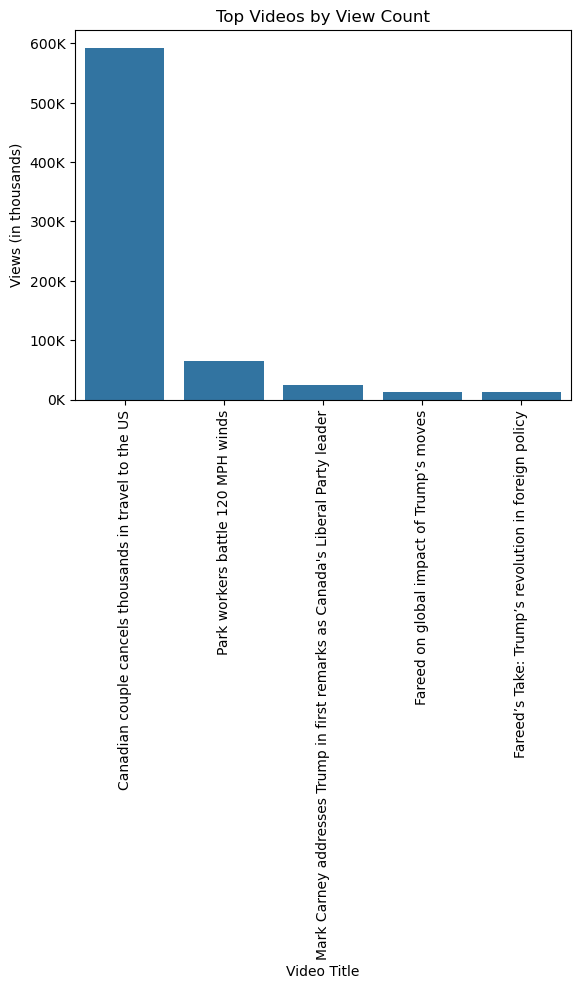

In [62]:
ax = sns.barplot(
    x="title",
    y="viewCount",
    data=video_df.sort_values("viewCount", ascending=False)[0:9],
)

# Fix xtick rotation issue
ax.set_xticks(range(len(video_df["title"])))  # Ensure fixed tick positions
ax.set_xticklabels(video_df["title"], rotation=90)


# Fix y-axis formatting (Convert to 'K' notation)

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:,.0f}K".format(x / 1000))
)

plt.title("Top Videos by View Count")
plt.ylabel("Views (in thousands)")
plt.xlabel("Video Title")

plt.show()


- ### Worst Performing Videos

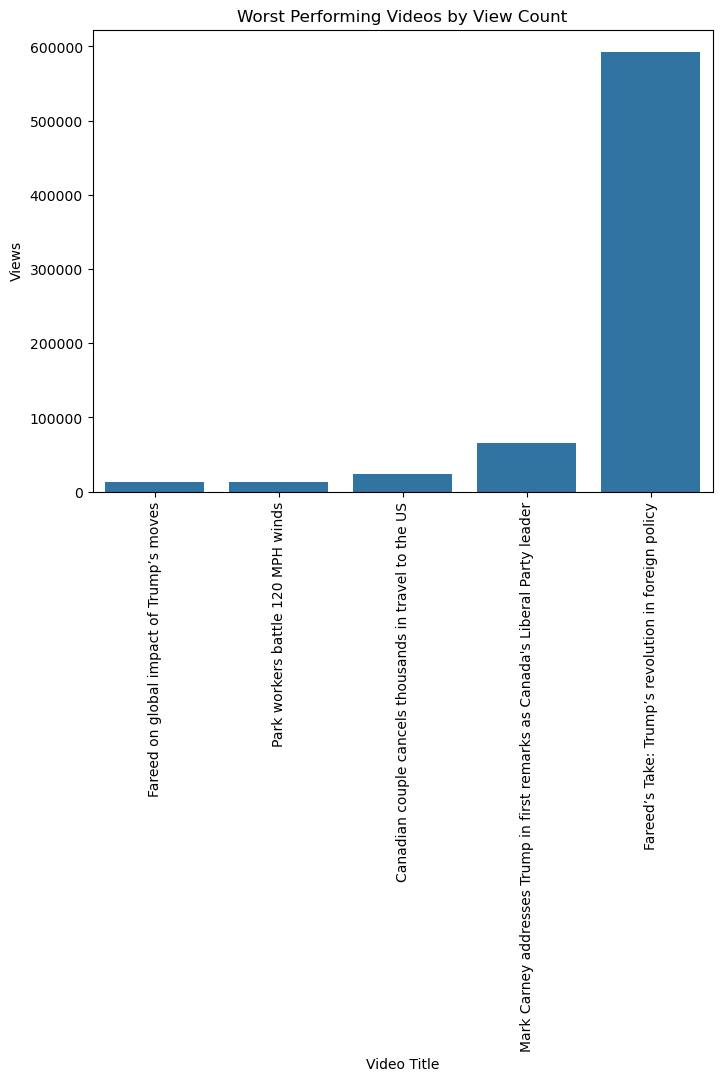

In [61]:
worst_videos = video_df.sort_values(
    "viewCount", ascending=True
).head()  # Get bottom 10 videos

worst_videos = video_df.sort_values("viewCount", ascending=True).head(10)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x="title", y="viewCount", data=worst_videos)

# Fix tick rotation issue
ax.set_xticks(range(len(worst_videos["title"])))  # Fix tick positions
ax.set_xticklabels(worst_videos["title"], rotation=90)

plt.title("Worst Performing Videos by View Count")
plt.ylabel("Views")
plt.xlabel("Video Title")

plt.show()


In [ ]:
ax = sns.barplot(
    x="title",
    y="viewCount",
    data=video_df.sort_values("viewCount", ascending=True)[0:9],
)

# format axis text

ax.set_xticks(range(len(video_df["title"])))  # Fix tick positions
ax.set_xticklabels(video_df["title"], rotation=90)

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x / 1000) + "K")
)

- ### View Distribution per video

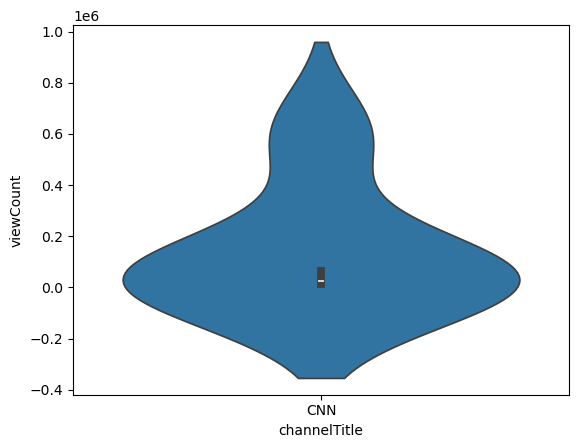

In [60]:
sns.violinplot(x=video_df["channelTitle"], y=video_df["viewCount"])

plt.show()


- ### Video Duration

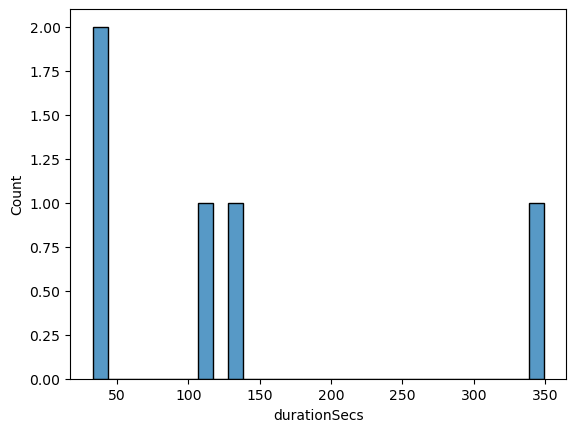

In [59]:
sns.histplot(data=video_df, x="durationSecs", bins=30)

plt.show()


In [ ]:
video_df

- ### WordCloud for video titles

In [ ]:
stop_words = set(stopwords.words("english"))
video_df["title_no_stopwords"] = video_df["title"].apply(
    lambda x: [item for item in str(x).split() if item not in stop_words]
)

all_words = list([a for b in video_df["title_no_stopwords"].tolist() for a in b])
all_words_str = " ".join(all_words)


def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis("off")


wordcloud = WordCloud(
    width=900,
    height=400,
    random_state=1,
    background_color="black",
    colormap="magma",
    collocations=False,
).generate(all_words_str)
plot_cloud(wordcloud)


In [ ]:
video_df

- ### Title length vs views

In [43]:
display(video_df.head())

if "duration" not in video_df.columns:
    raise ValueError("Error: 'duration' column is missing in the dataset.")


# Convert 'duration' from ISO 8601 format to seconds

def convert_duration(duration):
    try:
        return isodate.parse_duration(duration).total_seconds()
    except:
        return np.nan  # Handle invalid values


video_df["durationSecs"] = video_df["duration"].apply(convert_duration)

# Drop rows with missing duration

video_df = video_df.dropna(subset=["durationSecs"])

# Display summary statistics for duration

display(video_df[["durationSecs", "viewCount", "likeCount", "commentCount"]].describe())

# Convert numeric columns to integer type

video_df["viewCount"] = pd.to_numeric(video_df["viewCount"], errors="coerce")
video_df["likeCount"] = pd.to_numeric(video_df["likeCount"], errors="coerce")
video_df["commentCount"] = pd.to_numeric(video_df["commentCount"], errors="coerce")

# Drop NaN values in engagement metrics

video_df = video_df.dropna(subset=["viewCount", "likeCount", "commentCount"])




,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishDayName,durationSecs,tagCount,title_no_stopwords
0,WMGQiQDfuKM,CNN,Canadian couple cancels thousands in travel to...,CNN's Natasha Chen spoke to Gary and Carol Cru...,None,2025-03-10 02:10:37+00:00,24071.0,875.0,NaN,156.0,PT2M10S,hd,false,Monday,130.0,0,"[Canadian, couple, cancels, thousands, travel,..."
1,V5ypd7kJYh8,CNN,Park workers battle 120 MPH winds,Park workers braved heavy winds as gusts of ov...,None,2025-03-10 02:03:36+00:00,13350.0,552.0,NaN,30.0,PT33S,hd,false,Monday,33.0,0,"[Park, workers, battle, 120, MPH, winds]"
2,AqTvAZuwWlU,CNN,Mark Carney addresses Trump in first remarks a...,Mark Carney has been elected leader of Canada’...,None,2025-03-10 01:09:23+00:00,65407.0,4854.0,NaN,611.0,PT38S,hd,false,Monday,38.0,0,"[Mark, Carney, addresses, Trump, first, remark..."
3,7iZka5ewiQI,CNN,Fareed on global impact of Trump’s moves,"CNN’s Fareed Zakaria, host of “Fareed Zakaria ...",None,2025-03-09 22:09:51+00:00,12942.0,529.0,NaN,78.0,PT1M54S,hd,false,Sunday,114.0,0,"[Fareed, global, impact, Trump’s, moves]"
4,l_w-H7x4FwA,CNN,Fareed’s Take: Trump’s revolution in foreign p...,"Fareed Zakaria, host of “Fareed Zakaria GPS,” ...",None,2025-03-09 19:04:48+00:00,592868.0,11860.0,NaN,4067.0,PT5M49S,sd,true,Sunday,349.0,0,"[Fareed’s, Take:, Trump’s, revolution, foreign..."


,durationSecs,viewCount,likeCount,commentCount
count,5.000000,5.000000,5.00000,5.000000
mean,132.800000,141727.600000,3734.00000,988.400000
std,128.501751,253111.689264,4895.33722,1736.408448
min,33.000000,12942.000000,529.00000,30.000000
25%,38.000000,13350.000000,552.00000,78.000000
50%,114.000000,24071.000000,875.00000,156.000000
75%,130.000000,65407.000000,4854.00000,611.000000
max,349.000000,592868.000000,11860.00000,4067.000000


- ### Duration Vs. Views

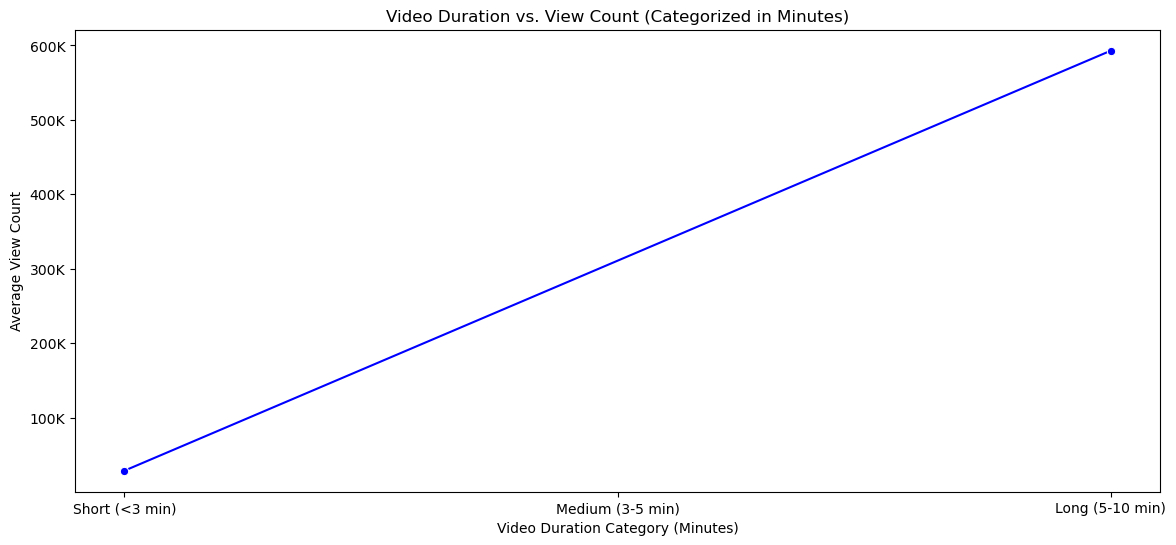

In [ ]:
# Create new column - durationMins
video_df["durationMins"] = video_df["durationSecs"] / 60  # Convert to minutes

# Define duration categories (in minutes)
bins = [0, 3, 5, 10, 60]  # <3 min, 3-5 min, 5-10 min, 10+ min
labels = ["Short (<3 min)", "Medium (3-5 min)", "Long (5-10 min)", "Very Long (10+ min)"]
video_df["durationCategory"] = pd.cut(video_df["durationMins"], bins=bins, labels=labels)

# Group by duration category and calculate averages
video_df_grouped = video_df.groupby("durationCategory", as_index=False, observed=False).agg({
    "viewCount": "mean",
    "likeCount": "mean"
})

plt.figure(figsize=(14,6))
ax1 = sns.lineplot(data=video_df_grouped, x="durationCategory", y="viewCount", marker="o", linestyle="-", color="b")

# Format Y-axis in 'K' notation
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x/1000:,.0f}K"))

plt.xlabel("Video Duration Category (Minutes)")
plt.ylabel("Average View Count")
plt.title("Video Duration vs. View Count (Categorized in Minutes)")

plt.show()

- ### Duration Vs. Likes

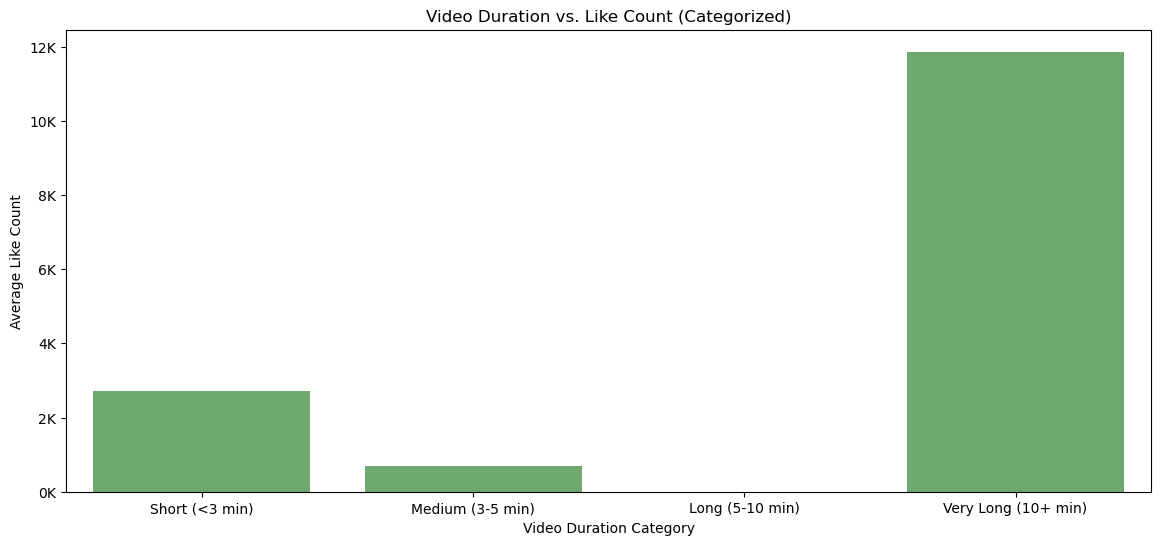

In [56]:
# Categorize durations
bins = [0, 60, 180, 300, 600]  # 0-1 min, 1-3 min, 3-5 min, 10+ min
labels = ["Short (<3 min)", "Medium (3-5 min)", "Long (5-10 min)", "Very Long (10+ min)"]
video_df["durationCategory"] = pd.cut(video_df["durationSecs"], bins=bins, labels=labels)

# Aggregate by category
video_df_grouped = video_df.groupby("durationCategory", as_index=False, observed=False)["likeCount"].mean() 

plt.figure(figsize=(14,6))
ax = sns.barplot(data=video_df_grouped, x="durationCategory", y="likeCount", color="green", alpha=0.6)

# Format Y-axis in 'K' notation
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x/1000:,.0f}K"))

plt.xlabel("Video Duration Category")
plt.ylabel("Average Like Count")
plt.title("Video Duration vs. Like Count (Categorized)")

plt.show()


- ### Video Length vs. Comments

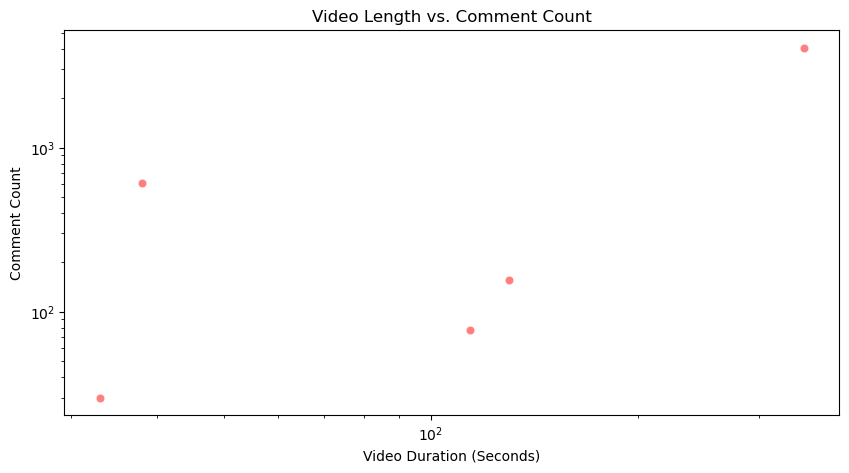

In [57]:
plt.figure(figsize=(10, 5))
sns.scatterplot(
    x=video_df["durationSecs"], y=video_df["commentCount"], alpha=0.5, color="red"
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Video Duration (Seconds)")
plt.ylabel("Comment Count")
plt.title("Video Length vs. Comment Count")

plt.show()


- ### Compute correlation matrix

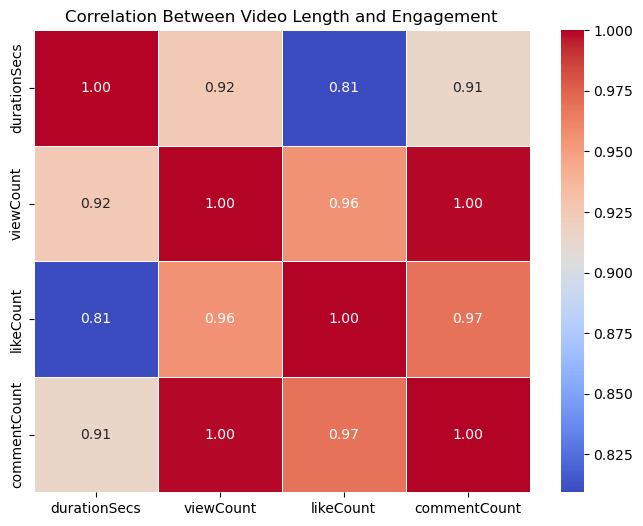

Longer videos tend to get more views.
Longer videos receive more likes on average.
Longer videos generate more comments.


In [58]:
correlation_matrix = video_df[
    ["durationSecs", "viewCount", "likeCount", "commentCount"]
].corr()

# Display heatmap of correlations

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Video Length and Engagement")
plt.show()

# Interpretation

if correlation_matrix.loc["durationSecs", "viewCount"] > 0:
    print("Longer videos tend to get more views.")
else:
    print("Shorter videos tend to get more views.")

if correlation_matrix.loc["durationSecs", "likeCount"] > 0:
    print("Longer videos receive more likes on average.")
else:
    print("Shorter videos receive more likes.")

if correlation_matrix.loc["durationSecs", "commentCount"] > 0:
    print("Longer videos generate more comments.")
else:
    print("Shorter videos generate more comments.")

plt.show()
